In [116]:
%matplotlib notebook
from matplotlib import rcParams
import matplotlib.pyplot as plt

import numpy as np
import numpy.linalg as la

import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.interpolate import interp2d, interp1d

import scipy.fftpack as fft

import timeit

In [2]:
rcParams.update({'font.size': 12})

In [3]:
# To more easily compare with matlab outputs
np.set_printoptions(precision=8)
np.set_printoptions(suppress=True)

Here is the structure of the program with possible improvments listed in <span style="color:gray;">gray</span> and actualized improvments listed in <span style="color:blue;">blue</span>.
* Before the loop, setup grid and initialize variables.
* $u^*$, $v^*$ = advectDiffuse
    * u_adv, v_adv are calculated from upwinding
        * <span style="color:gray;">a. Use Lax-Wendroff to compute uadv,vadv at the t+dt/2</span>
        * <span style="color:blue;">b. Use 2nd-order centered-differences</span>
        * <span style="color:gray;">c. Use 4th-order compact differencing to compute grad(u) and grad(v)</span>
        * <span style="color:gray;">d. Use either (b) and (c) and an extrapolation routine to approximate the advective derivatives at t + dt. This will require storing the values of advDerivU and advDerivV from the previous time-step.</span>
    * update ghost nodes for implicit solve
    * calculate $u^*$ and $v^*$ via Crank-Nicholson using sparse solver
        * <span style="color:gray;">a. Use ADI</span>
        * <span style="color:blue;">b. Use a fast direct solver based on the fast sine transform.</span>
        * <span style="color:gray;">c. Use multigrid</span>
        * <s><span style="color:blue;">d. Use conjugate gradient method (look at the pcg function in MATLAB).</span></s>
        * <span style="color:gray;">e. Pre-compute Cholesky factorization of the matrices and use them at each time-step to solve system (not the best improvement).</span>
        * <span style="color:gray;">Use an alternative to Crank Nicholson</span>
            * <span style="color:gray;">a. Use the TR-BDF2 method to advance the system in time.</span>
            * <span style="color:gray;">b. Include the gradient of the pressure in the time update</span>
            * <span style="color:gray;">c. Use a 4th-order compact scheme for the Laplacian.</span>
    * update ghost nodes for explicit solve
* p, lgmult = pressure
    * calculate the divergence (ie right-hand side)
    * find pressure-correction using sparse solver and a Lagrange multiplier
        * <span style="color:blue;">a. Use a fast cosine transform solver
        * <span style="color:gray;">b. Use an iterative method like multigrid
        * <s><span style="color:blue;">c. Pre-compute LU factorization of laplacian matrix and use it each time-step to solve system (not the best improvement).</s>
        * <span style="color:gray;">a.  Use 4th order compact scheme
    * update the ghost nodes
* $u^{n+1}$, $v^{n+1}$ = correct
    * compute the pressure gradient
        * <span style="color:gray;">a. Use compact scheme for computing the gradient</span>
    * calculate $u^{n+1}$ from $u^*$ and the pressure gradient
    * calculate $v^{n+1}$ from $v^*$ and the pressure gradient

# Parameters

# Functions

In [94]:
def setup_grid(m, h, k, Re):
    grid = {}
    
    grid['h'] = h
    grid['k'] = k
    
    grid['mu'] = (m+2, m+1) # (muy, mux)
    grid['mv'] = (m+1, m+2) # (mvy, mvx)
    grid['mp'] = (m+2, m+2) # (mpy, mpx)
    
    alpha = .5*k/Re
    
    # Laplacian for pressure
    
#     D2x = 1/h**2 * sp.diags([ [-2]*m, [1]*(m-1), [1]*(m-1) ], offsets=[0,1,-1], 
#                             format='lil')
#     # modify for Neumann BCs
#     D2x[ 0, 0] = -D2x[0,1]
#     D2x[-1,-1] = -D2x[-1,-2]
    
#     Lp = sp.lil_matrix((m**2+1, m**2+1))
#     Lp[:-1,:-1] = sp.kron(D2x,sp.eye(m)) + sp.kron(sp.eye(m), D2x)
#     # lagrange multiplier
#     Lp[-1, :-1] = np.ones(m**2)
#     Lp[:-1, -1] = np.ones(m**2).reshape((m**2,1))
#     grid['Lp'] = Lp.tocsr()
#     grid['Lp_ilu'] = spla.LinearOperator(Lp.shape,spla.spilu(Lp.tocsc()).solve)
#     grid['Lp_previous'] = None

    grid['u_adv_previous'] = None
    grid['v_adv_previous'] = None
    
    mx, my = m-1, m
    I = sp.eye(m*(m-1))
    # Laplacian for diffusion of u

#     D2x = 1/h**2 * sp.diags([ [-2]*mx, [1]*(mx-1), [1]*(mx-1) ], offsets=[0,1,-1], 
#                             format='lil')
#     D2y = 1/h**2 * sp.diags([ [-2]*my, [1]*(my-1), [1]*(my-1) ], offsets=[0,1,-1], 
#                             format='lil')
#     # Account for implicit boundary conditions
#     D2y[ 0, 0] = -3*D2y[0,1]
#     D2y[-1,-1] = -3*D2y[-1,-2]
    
#     grid['Lu'] = sp.kron(D2x,sp.eye(my)) + sp.kron(sp.eye(mx), D2y)

#     grid['implicit_Lu'] = (I - alpha*grid['Lu']).tocsc()
#     grid['Lu_ilu'] = spla.LinearOperator(grid['implicit_Lu'].shape,
#                                          spla.spilu(grid['implicit_Lu']).solve)
#     grid['Lu_previous'] = None
    
    mx, my = my, mx
    # Laplacian for diffusion of v
    
    D2x = 1/h**2 * sp.diags([ [-2]*mx, [1]*(mx-1), [1]*(mx-1) ], offsets=[0,1,-1], 
                            format='lil')
    D2y = 1/h**2 * sp.diags([ [-2]*my, [1]*(my-1), [1]*(my-1) ], offsets=[0,1,-1], 
                            format='lil')
    # Account for implicit boundary conditions
    D2x[ 0, 0] = -3*D2x[0,1]
    D2x[-1,-1] = -3*D2x[-1,-2]
    
    grid['Lv'] = sp.kron(D2x,sp.eye(my)) + sp.kron(sp.eye(mx), D2y)
    grid['implicit_Lv'] = (I - alpha*grid['Lv']).tocsc()
    grid['Lv_ilu'] = spla.LinearOperator(grid['implicit_Lv'].shape,
                                         spla.spilu(grid['implicit_Lv']).solve)
    grid['Lv_previous'] = None
    
    return grid

def update_ghost_diffusion(u, v, ps, h, k, explicit=True):
    us = u.copy()
    vs = v.copy()
    
    # update u
    #   vertical
    us[:, 0] = np.zeros(len(us[:, 0]))
    us[:,-1] = np.zeros(len(us[:,-1]))
    #   horizontal
    us[0]  = 2*     k*np.diff(ps[ 1])/h  - explicit*us[ 1]
    us[-1] = 2*(1 + k*np.diff(ps[-2])/h) - explicit*us[-2]
    #   average corners
    us[ 0, 0] /= 2
    us[ 0,-1] /= 2
    us[-1, 0] /= 2
    us[-1,-1] /= 2
    
    # update v
    #   horizontal
    vs[ 0] = np.zeros(len(vs[ 0,:]))
    vs[-1] = np.zeros(len(vs[-1,:]))
    #   vertical
    vs[:, 0] = 2*k*np.diff(ps[:, 1])/h - explicit*vs[:, 1]
    vs[:,-1] = 2*k*np.diff(ps[:,-2])/h - explicit*vs[:,-2]
    #   average corners
    vs[ 0, 0] /= 2
    vs[ 0,-1] /= 2
    vs[-1, 0] /= 2
    vs[-1,-1] /= 2
    
    return us, vs
    
def ave_x(edge):
    return (edge[:,:-1] + edge[:,1:])/2
    
def ave_y(edge):
    return (edge[:-1,:] + edge[1:,:])/2

def ave_c(edge):
    ave = edge[:,:-1] + edge[:,1:]
    return (ave[:-1,:] + ave[1:,:])/4

def up_wind(us, vs, h):
    # compute (u,v).grad(u)
    U, V = ave_x(us[1:-1,:]), ave_x(vs[:,1:-1])
    
    pos_id = np.greater(U, 0)
    F = pos_id*us[1:-1,:-1] + np.logical_not(pos_id)*us[1:-1,1:]
    pos_id = np.greater(V, 0)
    G = pos_id*us[:-1,1:-1] + np.logical_not(pos_id)*us[1:,1:-1]
    # get v on vertical edges
    V = ave_c(vs[:,1:-1])
    u_adv = 1/h * (us[1:-1, 1:-1] * np.diff(F,1,1) + V*np.diff(G,1,0))
    
    # compute (u,v).grad(v)
    U, V = ave_y(us[1:-1,:]), ave_y(vs[:,1:-1])
    pos_id = np.greater(U, 0)
    F = pos_id*vs[1:-1,:-1] + np.logical_not(pos_id)*vs[1:-1,1:]
    pos_id = np.greater(V, 0)
    G = pos_id*vs[:-1,1:-1] + np.logical_not(pos_id)*vs[1:,1:-1]
    # get u on horizontal edges
    U = ave_c(us[1:-1,:])
    v_adv = 1/h * (vs[1:-1, 1:-1] * np.diff(G,1,0) + U*np.diff(F,1,1))
    
    return u_adv, v_adv

# replace upwinding with second order centered differencing
def advect_O2_centered(us, vs, h):
    # update ghost nodes and boundaries
    us[0]  = -us[1]
    us[-1] = 2-us[-2] # u at top boudnary is 1
    us[:,0] = np.zeros(len(us[:,0]))
    us[:,-1] = np.zeros(len(us[:,-1]))
    vs[0] = np.zeros(len(vs[0]))
    vs[-1] = np.zeros(len(vs[-1]))
    vs[:,0] = -vs[:,1]
    vs[:,-1] = -vs[:,-2]
    
    # get v on vertical edges
    v_at_us = ave_c(vs[:,1:-1])
    F = (-us[1:-1,:-2] + us[1:-1,2:])/(2*h) # du/dx at us
    G = (-us[:-2,1:-1] + us[2:,1:-1])/(2*h) # du/dy at us
    u_adv = us[1:-1, 1:-1]*F + v_at_us*G
    
    # get u on vertical edges
    u_at_vs = ave_c(us[1:-1,:])
    F = (-vs[1:-1,:-2] + vs[1:-1,2:])/(2*h) # dv/dx at vs
    G = (-vs[:-2,1:-1] + vs[2:,1:-1])/(2*h) # dv/dy at vs
    v_adv = u_at_vs*F + vs[1:-1, 1:-1]*G
    return u_adv, v_adv

def laplacian(us, h):
    ret  = -4*us[1:-1, 1:-1]
    ret +=    us[ :-2, 1:-1]
    ret +=    us[1:-1,  :-2]
    ret +=    us[2:  , 1:-1]
    ret +=    us[1:-1, 2:  ]
    return ret/h**2

def poisson_u_dst(fs, h, alpha):
    my, mx = fs.shape
    # fhat=(S*f)*S^(-1)
    f_hat = fft.dst(fft.dst(fs, type=2, axis=0)/(mx+1),type=1, axis=1)/(my)
    y_vec = np.cos(np.pi*np.arange(1,my+1)/(my))
    x_vec = np.cos(np.pi*np.arange(1,mx+1)/(mx+1))
    denom = 1 - alpha/h**2 * 2*(np.add.outer(y_vec, x_vec)-2)
    u_hat = f_hat / denom
    us = fft.idst(fft.idst(u_hat, type=2, axis=0)/2,type=1, axis=1)/2
    return us

def poisson_v_dst(fs, h, alpha):
    my, mx = fs.shape
    # fhat=(S*f)*S^(-1)
    f_hat = fft.dst(fft.dst(fs, type=1, axis=0)/(mx),type=2, axis=1)/(my+1)
    y_vec = np.cos(np.pi*np.arange(1,my+1)/(my+1))
    x_vec = np.cos(np.pi*np.arange(1,mx+1)/(mx))
    denom = 1 - alpha/h**2 * 2*(np.add.outer(y_vec, x_vec)-2)
    u_hat = f_hat / denom
    us = fft.idst(fft.idst(u_hat, type=1, axis=0)/2,type=2, axis=1)/2
    return us

def advec_diffuse(us, vs, ps, h, k, Re, grid):
    #u_adv, v_adv = up_wind(us, vs, h)  
    u_adv, v_adv = advect_O2_centered(us, vs, h)
    
# ABII Midpoint Rule Modifications ######################
#     if grid['u_adv_previous'] is None:
#         grid['u_adv_previous'] = u_adv
#         grid['v_adv_previous'] = v_adv
        
#     u_adv_half = 3/2*u_adv - 1/2*grid['u_adv_previous']
#     v_adv_half = 3/2*v_adv - 1/2*grid['v_adv_previous']
#     grid['u_adv_previous'] = u_adv
#     grid['v_adv_previous'] = v_adv
#     u_adv, v_adv = u_adv_half, v_adv_half
# End ABII Midpoint Rule Modifications ##################
    
    u_star, v_star = update_ghost_diffusion(us, vs, ps, h, k, False)
    alpha = .5*k/Re
    
    # solve u first
    # Compute right hand-side (I+L)*u on the grid.
    f = us[1:-1, 1:-1] + alpha*laplacian(us,h) - k*u_adv
    # incorporate boundary conditions
    f[0]   += alpha/h**2 * u_star[0   ,1:-1]
    f[-1]  += alpha/h**2 * u_star[-1  ,1:-1]
    f[:,0] += alpha/h**2 * u_star[1:-1, 0  ]
    f[:,-1]+= alpha/h**2 * u_star[1:-1, -1 ]

    
    
#     test = poisson_u_dst(f, h, alpha)
    
    
#     f = f.flatten(order='F')
#     my, mx = [m-2 for m in us.shape]
#     #I = sp.eye(mx*my)
#     #u_star[1:-1, 1:-1] = spla.spsolve(I - alpha*grid['Lu'], f).reshape(mx,my, order='F')
    
#     cg_out = spla.cg(grid['implicit_Lu'], f, x0= grid['Lu_previous'], tol=cg_tol, 
#                        maxiter=cg_max_iter, M = grid['Lu_ilu'])
#     if cg_out[1] == 0:
#         grid['Lu_previous'] = cg_out[0]
#     else:
#         I = sp.eye(mx*my)
#         grid['Lu_previous'] = spla.spsolve(I - alpha*grid['Lu'], f).reshape(mx,my, order='F')
#     u_star[1:-1, 1:-1] = grid['Lu_previous'].reshape(my,mx, order='F')
    
    u_star[1:-1,1:-1] = poisson_u_dst(f, h, alpha)
#     print('DST error: %g' % la.norm(test - u_star[1:-1,1:-1]))
    
    # solve v second
    # Compute right hand-side (I+L)*u on the grid.
    f = vs[1:-1, 1:-1] + alpha*laplacian(vs,h) - k*v_adv
    
    # incorporate boundary conditions
    f[0]   += alpha/h**2 * v_star[0   ,1:-1]
    f[-1]  += alpha/h**2 * v_star[-1  ,1:-1]
    f[:,0] += alpha/h**2 * v_star[1:-1, 0  ]
    f[:,-1]+= alpha/h**2 * v_star[1:-1, -1 ]
    
#     f = f.flatten(order='F') # flatten stacks rows by default
#     my, mx = [m-2 for m in vs.shape]
#     cg_out = spla.cg(grid['implicit_Lv'], f, x0= grid['Lv_previous'], tol=cg_tol, 
#                        maxiter=cg_max_iter, M = grid['Lv_ilu'])
#     if cg_out[1] == 0:
#         grid['Lv_previous'] = cg_out[0]
#     else:
#         I = sp.eye(mx*my)
#         grid['Lv_previous'] = spla.spsolve(I - alpha*grid['Lv'], f).reshape(my,mx, order='F')
#     v_star[1:-1, 1:-1] = grid['Lv_previous'].reshape(my,mx, order='F')
    
    v_star[1:-1, 1:-1] = poisson_v_dst(f, h, alpha)
    
    #I = sp.eye(mx*my)
    #v_star[1:-1, 1:-1] = spla.spsolve(I - alpha*grid['Lv'], f).reshape(mx,my).T
    
    u_star, v_star = update_ghost_diffusion(u_star, v_star, ps, h, k, True)
    
    return u_star, v_star

def divergence(us, vs, h):
    return ( np.diff(us[1:-1],axis=1) + np.diff(vs[:,1:-1],axis=0) )/h

def poissondct2(fs, m, h):
    # fhat=(S*f)*S^(-1)
    f_hat = fft.dct(fft.dct(fs, type=2, axis=0)/2,type=2, axis=1)/(m)
    cos_vec = np.cos(np.pi*np.arange(0,m)/(m))
    denom = 2*(np.add.outer(cos_vec, cos_vec)-2)
    denom[0,0] = 1 #temporary to allow for the division
    u_hat = h**2 * f_hat / denom
    u_hat[0,0] = 0 # arbitrarily chosen
    us = fft.idct(fft.idct(u_hat, type=2, axis=0)/(m),type=2, axis=1)/2
    return us

def pressure(u_star, v_star, h, k, grid):
    div = divergence(u_star, v_star, h)/k
    my, mx = div.shape
    
    # find pressure-correction using sparse solver and a Lagrange multiplier
    ps = np.zeros(grid['mp'])
    
#     rhs = np.zeros(mx*my+1)
#     rhs[:-1] = div.flatten(order='F')
# #     pcr = spla.spsolve(grid['Lp'], rhs)
    
#     cg_out = spla.cg(grid['Lp'], rhs, x0=grid['Lp_previous'], tol=cg_tol, 
#                        maxiter=cg_max_iter, M = grid['Lp_ilu'])[0]
#     if cg_out[1] == 0:
#         pcr = cg_out[0]
#     else:
#         pcr = spla.spsolve(grid['Lp'], rhs)
    
#     grid['Lp_previous'] = pcr
#     lagrange_mult = pcr[-1]
#     ps[1:-1, 1:-1] = pcr[:-1].reshape((my, mx), order='F')
    
    # IMPROVMENT - use fast DCT solver instead of sparse direct solver
    ps[1:-1, 1:-1] = poissondct2(div, div.shape[0], h)
    lagrange_mult = None
    
    #ensure Neumann BCs
    ps[0] = ps[1]
    ps[-1] = ps[-2]
    ps[:,0] = ps[:,1]
    ps[:,-1] = ps[:,-2]
    
    return ps, lagrange_mult
    
def correct(us, vs, ps, h, k, grid):
    px = np.diff(ps[:,1:-1], axis=1)/h
    us[:,1:-1] -= k*px
    py = np.diff(ps[1:-1], axis=0)/h
    vs[1:-1,:] -= k*py
    return us, vs

def navier_stokes(m, L, CFL, Re, t0, t_final, log=True):
    h = L/m
    k = CFL*h
    t_steps = int((t_final-t0)/k)
    if log: print('initializing...')
    grid = setup_grid(m, h, k, Re)
    us = np.zeros(grid['mu'])
    vs = np.zeros(grid['mv'])
    ps = np.zeros(grid['mp'])
    if log: print('solving')
    
    for step in range(t_steps):
        if log and step % 100 == 0:
            print('step: %d/%d' % (step,t_steps), end='\r')
        u_star, v_star = advec_diffuse(us, vs, ps, h, k, Re, grid)
        ps, lagrange_mult = pressure(u_star, v_star, h, k, grid)
        us, vs = correct(u_star, v_star, ps, h, k, grid)
    if log: print('complete                   ')
    return us, vs, ps, grid

# Timings

In [101]:
%%timeit -n1 -r1
m = 2**7 #number of cell centers
L = 1    #length of side of square domain
CFL = 1  #max CFL number at which to run
Re = 100
t0, t_final = 0, 40

cg_tol = 1e-8
cg_max_iter = m**4

navier_stokes(m, L, CFL, Re, t0, t_final, log=True)

initializing...
solving
complete                   
20.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Solve

In [108]:
# parameters ************************************************************

m = 2**8 #2**6 #2**5 #number of cell centers
L = 1    #length of side of square domain
CFL = 1  # .5 #max CFL number at which to run

Re = 1000

t0, t_final = 0, 40

cg_tol = 1e-8
cg_max_iter = m**4

In [109]:
us, vs, ps, grid = navier_stokes(m, L, CFL, Re, t0, t_final)

initializing...
solving
complete                   


# Compare to GGS82 and MSA09 data

In [110]:
muy, mux = grid['mu']
mvy, mvx = grid['mv']
mpy, mpx = grid['mp']
h = L/m
X_u, Y_u = np.meshgrid(np.linspace(0,L,mux), np.linspace(-h/2,L+h/2,muy))
X_v, Y_v = np.meshgrid(np.linspace(-h/2,L+h/2,mvx), np.linspace(0,L,mvy))
X_p, Y_p = np.meshgrid(np.linspace(-h/2,L+h/2,mpx), np.linspace(-h/2,L+h/2,mpy))

# for grid data
grid_points_u = [(x,y) for x,y in zip(X_u, Y_u)]

In [111]:
# plt.figure(figsize=(5,5))
# plt.plot([0,0], [0,h*8/2], 'k--')
# plt.plot([0, h*8/2], [0,0], 'k--')
# plt.plot(X_u[:5,:5].flatten(), Y_u[:5,:5].flatten(), 'b<', label='$u$')
# plt.plot(X_v[:5,:5].flatten(), Y_v[:5,:5].flatten(), 'gv', label='$v$')
# plt.plot(X_p[:5,:5].flatten(), Y_p[:5,:5].flatten(), 'ro', label='$p$')
# plt.legend()
# plt.show()

In [119]:
#data locations for u component of velocity from GGS82
idys = [128, 125, 124, 123, 122, 109, 94, 79, 64, 58, 36, 22, 13, 9, 8, 7, 0]
ys_uG = [i/128 for i in idys]
xs_uG = [.5]#*len(ys_uG)

#data locations for v component of velocity from GGS82
idx = [128, 124, 123, 122, 121, 116, 110, 103, 64, 30, 29, 20, 12, 10, 9, 8, 0]
xs_vG = [i/128 for i in idx]
ys_vG = [.5]#*len(xs_vM)

#data locations for u component of velocity from MSA09
ys_uM = np.linspace(0,1, 17)[1:-1]
xs_uM = [.5]#*len(ys_uM)

#data locations for v component of velocity from MSA09
xs_vM = np.linspace(0,1, 17)[1:-1]
ys_vM = [.5]#*len(xs_vM)



# Determine the values for comparison to GS82
if Re == 100:
    # Values of u at (xiu,yiu)
    uGGS82 = [1,0.84123,0.78871,0.73722,0.68717,0.23151,
              0.00332,-0.13641,-0.20581,-0.21090,-0.15662,
              -0.10150,-0.06434,-0.04775,-0.04192,-0.03717,0];
    uMSA09 = [-0.041974991, -0.077125399, -0.109816214, -0.141930064, 
              -0.172712391, -0.198470859, -0.212962392, -0.209149142, 
              -0.182080595, -0.131256301, -0.060245594, 0.027874448, 
              0.140425325, 0.310557090, 0.597466694]
    # Values of v at (xiv,yiv)
    vGGS82 = [0,-0.05906,-0.07391,-0.08864,-0.10313,-0.16914,
              -0.22445,-0.24533,0.05454,0.17527,0.17507,0.16077,
              0.12317,0.10890,0.10091,0.09233,0];
    vMSA09 = [0.094807616, 0.149243000, 0.174342933, 0.179243328, 
              0.169132064, 0.145730201, 0.108775865, 0.057536559, 
              -0.007748504, -0.084066715, -0.163010143, -0.227827313, 
              -0.253768577, -0.218690812, -0.123318170]
elif Re == 400:
    # Values of u at (xiu,yiu)
    uGGS82 = [1, 0.75837, 0.68439, 0.61756, 0.55892, 0.29093, 
              0.16256, 0.02135, -0.11477, -0.17119, -0.32726, 
              -0.24299, -0.14612, -0.10338, -0.09266, -0.08186, 0]
    uMSA09 = [-0.092599260, -0.178748051, -0.263917200, -0.321229080, 
              -0.320251090, -0.266306350, -0.190730560, -0.115053628, 
              -0.042568947, 0.030243020, 0.105456010, 0.181306850, 
              0.252203840, 0.316829690, 0.469580199]
    # Values of v at (xiv,yiv)
    vGGS82 = [0, -0.12146, -0.15663, -0.19254, -0.22847, -0.23827, 
              -0.44993, -0.38598, 0.05186, 0.30174, 0.30203, 0.28124, 
              0.22965, 0.20920, 0.19713, 0.18360, 0]
    vMSA09 = [0.185132290, 0.262251260, 0.297479230, 0.300960030, 
              0.268310960, 0.206571390, 0.130571694, 0.052058082, 
              -0.024714514, -0.100884164, -0.182109238, -0.280990219, 
              -0.400042350, -0.449011850, -0.270354943]
elif Re == 1000:
    # Values of u at (xiu,yiu)
    uGGS82 = [1,0.65928,0.57492,0.51117,0.46604,0.33304,0.18719,
              0.05702,-0.06080,-0.10648,-0.27805,-0.38289,-0.29370,
              -0.22220,-0.20196,-0.18109,0];
    uMSA09 = [-0.202330048, -0.347845100, -0.384409400, -0.318946100, 
              -0.245693700, -0.183732100, -0.123410460, -0.062056130, 
              0.000561800, 0.065248742, 0.133572570, 0.207914610, 
              0.288442400, 0.362545400, 0.422932100]
    # Values of v at (xiv,yiv)
    vGGS82 = [0,-0.21388,-0.27669,-0.33714,-0.39188,-0.51550,
              -0.42665,-0.31966,0.02526,0.32235,0.33075,0.37095,
              0.32627,0.30353,0.29012,0.27485,0]
    vMSA09 = [0.28070570, 0.36504180, 0.36785270, 0.30710428, 
              0.23126839, 0.16056422, 0.09296931, 0.02579946, 
              -0.04184068, -0.11079830, -0.18167970, -0.25338150, 
              -0.33156670, -0.46777560, -0.45615254]
    
# interpolate to values
us_interp_G = np.interp(ys_uG, Y_u[:,mux//2], us[:,mux//2])
us_interp_M = np.interp(ys_uM, Y_u[:,mux//2], us[:,mux//2])

#v_interp_func = interp2d(X_v, Y_v, vs, kind='linear')
vs_interp_G = np.interp(xs_vG, X_v[muy//2-1], vs[muy//2-1])
vs_interp_M = np.interp(xs_vM, X_v[muy//2-1], vs[muy//2-1])

<IPython.core.display.Javascript object>


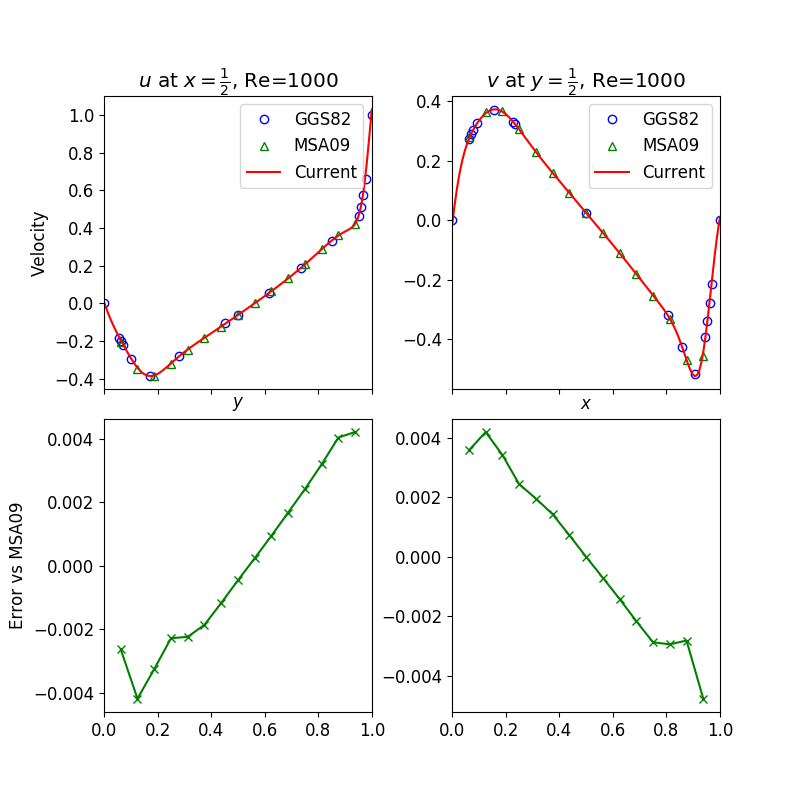

In [120]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(8,8))
plt.subplots_adjust(left=.13, wspace=.3, hspace=.1)

# plot u
axes[0,0].set_xlim((0,1))
axes[0,0].set_title('$u$ at $x=\\frac{1}{2}$, Re=%d' % Re)
axes[0,0].set_xlabel('$y$')
axes[0,0].set_ylabel('Velocity')
axes[0,0].plot(ys_uG, uGGS82, 'bo', fillstyle='none', label='GGS82')
axes[0,0].plot(ys_uM, uMSA09, 'g^', fillstyle='none', label='MSA09')
axes[0,0].plot(np.linspace(0,L,muy), us[:,mux//2], 'r-', label='Current')
axes[0,0].legend()

# plot u error vs MSA09
axes[1,0].set_ylabel('Error vs MSA09')
axes[1,0].plot(ys_uM, np.array(uMSA09)-us_interp_M.flatten(), 'gx-')

# plot v
axes[0,1].set_title('$v$ at $y=\\frac{1}{2}$, Re=%d' % Re)
axes[0,1].set_xlabel('$x$')
axes[0,1].plot(xs_vG, vGGS82, 'bo', fillstyle='none', label='GGS82')
axes[0,1].plot(xs_vM, vMSA09, 'g^', fillstyle='none', label='MSA09')
axes[0,1].plot(np.linspace(0,L,muy), vs[muy//2-1], 'r-', label='Current')
axes[0,1].legend()

#plot v error vs MSA09
axes[1,1].plot(xs_vM, np.array(vMSA09)-vs_interp_M.flatten(), 'gx-')

plt.show()

# DCT and DST Eigenvalues

<table style="font-size:16px">
<tr>
<td><p>
<b>DCT-I</b> <br>
Node centered <br>
Neumann BCS <br>
$m$ points including boundaries <br>
$\lambda_i = 2\cos\big(\frac{\pi i}{m-1}\big)-2$ for $i=0, 1, \dots, m-1$
</p></td>
<td>
Stencil: $\begin{bmatrix}-2&2&&&\\1&-2&1&&\\&\ddots&\ddots&\ddots&\\&&1&-2&1\\&&&2&-2\end{bmatrix}$
</td>
</tr>

<tr>
<td><p>
<b>DCT-II</b> <br>
    Cell centered<br>
    Neumann BCS<br>
    $m$ points in cell centers<br>
    $\lambda_i = 2\cos\big(\frac{\pi i}{m}\big)-2$ for $i=0, 1, \dots, m-1$<br>
</p></td>
<td>
Stencil: $\begin{bmatrix}-1&1&&&\\1&-2&1&&\\&\ddots&\ddots&\ddots&\\&&1&-2&1\\&&&1&-1\end{bmatrix}$
</td>
</tr>

<tr>
<td><p>
<b>DST-I</b>
    Node centered<br>
    Dirichlet BCS<br>
    $m$ interior points<br>
    $\lambda_i = 2\cos\big(\frac{\pi i}{m+1}\big)-2$ for $i=1, 2, \dots, m$<br>
</p></td>
<td>
Stencil: $\begin{bmatrix}-2&1&&&\\1&-2&1&&\\&\ddots&\ddots&\ddots&\\&&1&-2&1\\&&&1&-2\end{bmatrix}$
</td>
</tr>

<tr>
<td><p>
<b>DST-II</b>

    Node centered<br>
    Dirichlet BCS<br>
    $m$ interior points at cell centers<br>
    $\lambda_i = 2\cos\big(\frac{\pi i}{m}\big)-2$ for $i=1, 2, \dots, m$<br>
</p></td>
<td>
Stencil: $\begin{bmatrix}-3&1&&&\\1&-2&1&&\\&\ddots&\ddots&\ddots&\\&&1&-2&1\\&&&1&-3\end{bmatrix}$
</td>
</tr>
</table>

In [70]:
# parameters ************************************************************

m = 2**3 #2**6 #2**5 #number of cell centers
L = 1    #length of side of square domain
CFL = 1  # .5 #max CFL number at which to run

Re = 400

t0, t_final = 0, 10

cg_tol = 1e-8
cg_max_iter = m**4

us, vs, ps, grid = navier_stokes(m, L, CFL, Re, t0, t_final)

h = grid['h']
k = grid['k']

# Compute right hand-side (I+L)*u on the grid.
u_adv, v_adv = advect_O2_centered(us, vs, h)
u_star, v_star = update_ghost_diffusion(us, vs, ps, h, k, False)
alpha = .5*k/Re
f = vs[1:-1, 1:-1] + alpha*laplacian(vs,h) - k*v_adv 
# incorporate boundary conditions
f[0]   += alpha/h**2 * v_star[0   ,1:-1]
f[-1]  += alpha/h**2 * v_star[-1  ,1:-1]
f[:,0] += alpha/h**2 * v_star[1:-1, 0  ]
f[:,-1]+= alpha/h**2 * v_star[1:-1, -1 ]
f_flat = f.flatten(order='F')

my, mx = [m-2 for m in vs.shape]
I = sp.eye(mx*my)
L = (I - alpha*grid['Lv']).tocsr()

    
# parameters ************************************************************
out_flat = spla.spsolve(L, f_flat)
print(la.norm(L@out_flat-f_flat))

out = out_flat.reshape(my, mx, order='F')
assert vs[1:-1,1:-1].shape == out.shape

initializing...
solving
complete                   
1.171717106656548e-16


In [75]:
D2x = sp.diags([ [-2]*mx, [1]*(mx-1), [1]*(mx-1) ], offsets=[0,1,-1], 
                        format='lil')
D2y = sp.diags([ [-2]*my, [1]*(my-1), [1]*(my-1) ], offsets=[0,1,-1], 
                        format='lil')
# Account for implicit boundary conditions
D2x[ 0, 0] = -3*D2x[0,1]
D2x[-1,-1] = -3*D2x[-1,-2]

In [76]:
D2y@out + out@D2x - (h**2*grid['Lv'] @ out.flatten(order='F')).reshape(my, mx, order='F')

array([[ 0.,  0.,  0., -0.,  0.,  0., -0.,  0.],
       [ 0.,  0., -0.,  0.,  0., -0.,  0., -0.],
       [ 0.,  0., -0., -0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -0.,  0., -0., -0.,  0.],
       [-0., -0.,  0.,  0., -0.,  0.,  0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-0.,  0.,  0.,  0.,  0.,  0.,  0., -0.]])

In [77]:
out - alpha/h**2 * (D2y@out + out@D2x) - f

array([[ 0.,  0.,  0.,  0.,  0.,  0., -0.,  0.],
       [-0., -0.,  0.,  0., -0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -0.,  0., -0., -0.],
       [-0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-0.,  0.,  0.,  0., -0., -0.,  0.,  0.],
       [ 0.,  0., -0., -0., -0., -0.,  0.,  0.],
       [-0.,  0.,  0., -0., -0., -0.,  0.,  0.]])

In [90]:
def poisson_v_dst(fs, h, alpha):
    my, mx = fs.shape
    # fhat=(S*f)*S^(-1)
    f_hat = fft.dst(fft.dst(fs, type=1, axis=0)/(mx),type=2, axis=1)/(my+1)
    y_vec = np.cos(np.pi*np.arange(1,my+1)/(my+1))
    x_vec = np.cos(np.pi*np.arange(1,mx+1)/(mx))
    denom = 1 - alpha/h**2 * 2*(np.add.outer(y_vec, x_vec)-2)
    u_hat = f_hat / denom
    us = fft.idst(fft.idst(u_hat, type=1, axis=0)/2,type=2, axis=1)/2
    return us

In [89]:
out2 = poisson_v_dst(f, h, alpha)
print(la.norm(out2 - out))
print(out2-out)

2.451056693012897e-16
[[-0.  0.  0. -0.  0.  0.  0.  0.]
 [ 0.  0. -0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -0.]
 [ 0.  0.  0.  0. -0.  0. -0. -0.]
 [-0.  0.  0.  0.  0.  0. -0. -0.]
 [-0.  0.  0.  0.  0.  0. -0.  0.]
 [-0. -0. -0. -0.  0.  0. -0. -0.]]


In [361]:
x = np.random.randn(7)
print(la.norm(x - fft.idst(fft.dst(x, type=1)/(7+1), type=1)/2))
print(la.norm(x - fft.idst(fft.dst(x, type=2)/7, type=2)/2))

7.791361360319881e-16
9.694605782913356e-16


array([-0.,  0.,  0.,  0., -0.,  0.,  0.])

array([ 0., -0.,  0.,  0.,  0., -0.,  0.])

In [298]:
1/7/2

0.07142857142857142

In [289]:
L = np.diag(np.arange(1,6))
x = np.random.randn(5,5)

In [293]:
L@x - (x@L)

array([[ 0.   , -0.561,  3.422,  3.989, -1.814],
       [ 0.397,  0.   ,  0.184,  1.056, -3.552],
       [ 0.946,  0.044,  0.   , -0.411, -1.39 ],
       [-1.185, -0.413,  1.683,  0.   , -0.295],
       [-1.485,  3.038, -2.141,  0.173,  0.   ]])

I need to solve $(I - \alpha*L)\vec{u} = \vec{f}$ which can be written in the follwing matrix form

$$
U - \alpha ( D_yU + UD_x) = F
$$

Let $S_1$ and $S_2$ represent the DST-I and DST-II in matrix form repspectively. Then $S_1^{-1}D_xS_1 = \Lambda_x$ and $S_2^{-1}D_yS_2 = \Lambda_y$ are diagonal matrices. 

We can apply the DST-I to our equation to arrive at
$$
U^x - \alpha D_y^xU^x + U^x\Lambda_x
$$